In [1]:
import pandas as pd
import nltk
import re
from collections import Counter
import random
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.classify.util import accuracy
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import gc  # Garbage collection for memory management

# Download required NLTK data
nltk.download("punkt_tab", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("averaged_perceptron_tagger", quiet=True)
nltk.download("vader_lexicon", quiet=True)


True

In [2]:
# Memory-efficient data loading
print("Loading dataset...")
df = pd.read_csv("train.tsv", sep="\t")

# Sample data if too large (for memory efficiency)
if len(df) > 50000:
    print(f"Dataset has {len(df)} rows. Sampling 50,000 for memory efficiency...")
    df = df.sample(n=50000, random_state=42).reset_index(drop=True)

print("Dataset shape:", df.shape)
print("Sentiment distribution:")
print(df['Sentiment'].value_counts())

Loading dataset...
Dataset has 156060 rows. Sampling 50,000 for memory efficiency...
Dataset shape: (50000, 4)
Sentiment distribution:
Sentiment
2    25202
3    10691
1     8792
4     3034
0     2281
Name: count, dtype: int64


In [3]:
# Initialize tools
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

def preprocess_text(text, remove_stopwords=True):
    """Memory-efficient text preprocessing"""
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

# Process text in batches to save memory
print("Preprocessing text...")
df['tokens'] = df['Phrase'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

Preprocessing text...


In [4]:

# Create vocabulary from most frequent words (smaller vocab for memory)
print("Building vocabulary...")
all_tokens = []
for tokens in df['tokens']:
    all_tokens.extend(tokens)

word_freq = Counter(all_tokens)
# Use smaller vocabularies to save memory
top_500_words = set([word for word, freq in word_freq.most_common(500)])
top_1000_words = set([word for word, freq in word_freq.most_common(1000)])

# Clear memory
del all_tokens, word_freq
gc.collect()

Building vocabulary...


0

In [5]:
# Feature Engineering Functions (Memory Optimized)

def basic_bag_of_words(tokens, vocab):
    """Basic bag-of-words features - optimized"""
    return {f'has_{word}': (word in tokens) for word in vocab if word in tokens}

def negation_features(text):
    """Enhanced negation handling - simplified for memory"""
    features = {}
    text_lower = str(text).lower()

    # Simple negation detection
    negation_words = ['not', 'no', 'never', "n't", 'without', 'hardly']
    has_negation = any(neg in text_lower for neg in negation_words)
    features['has_negation'] = has_negation

    if has_negation:
        # Count negation words
        features['negation_count'] = sum(1 for neg in negation_words if neg in text_lower)

    return features

def sentiment_lexicon_features(text):
    """Sentiment lexicon features using VADER - simplified"""
    scores = sia.polarity_scores(str(text))

    return {
        'vader_pos': scores['pos'] > 0.1,
        'vader_neg': scores['neg'] > 0.1,
        'vader_compound_pos': scores['compound'] > 0.05,
        'vader_compound_neg': scores['compound'] < -0.05,
        'vader_compound_score': round(scores['compound'], 2)  # Discretized
    }

def pos_features_simple(tokens):
    """Simplified POS features to save memory"""
    if not tokens:
        return {}

    # Only for first 10 tokens to save memory
    sample_tokens = tokens[:10]
    try:
        pos_tags = nltk.pos_tag(sample_tokens)
        pos_counts = Counter([tag for _, tag in pos_tags])

        # Only track major POS categories
        return {
            'has_adjectives': any(tag.startswith('JJ') for tag in pos_counts),
            'has_adverbs': any(tag.startswith('RB') for tag in pos_counts),
            'has_verbs': any(tag.startswith('VB') for tag in pos_counts),
            'adj_count': sum(1 for tag in pos_counts if tag.startswith('JJ')),
        }
    except:
        return {}

def text_structure_features(text, tokens):
    """Simple text structure features"""
    text_str = str(text)
    return {
        'is_short': len(tokens) < 5,
        'is_long': len(tokens) > 15,
        'has_exclamation': '!' in text_str,
        'has_question': '?' in text_str,
        'has_caps': any(c.isupper() for c in text_str),
        'word_count_bin': min(len(tokens) // 3, 5)  # Binned word count
    }

# Memory-efficient feature creation
def create_features_efficiently(df, feature_type):
    """Create features one at a time to manage memory"""
    features = []

    for idx, row in df.iterrows():
        if idx % 5000 == 0:
            print(f"Processing row {idx}/{len(df)}")
            gc.collect()  # Clean up memory periodically

        # Initialize feat to an empty dictionary to handle unrecognized feature_types
        feat = {}

        if feature_type == 'bow_500':
            feat = basic_bag_of_words(row['tokens'], top_500_words)
        elif feature_type == 'bow_1000':
            feat = basic_bag_of_words(row['tokens'], top_1000_words)
        elif feature_type == 'bow_5000':
             # Create top_2000_words if needed, or handle this case appropriately
            if 'top_5000_words' not in globals():
                 print("Warning: 'top_5000_words' not defined. Skipping bow_5000.")
                 continue # Skip to next row if vocabulary is missing
            feat = basic_bag_of_words(row['tokens'], top_5000_words)
        elif feature_type == 'negation':
            feat = negation_features(row['Phrase'])
        elif feature_type == 'sentiment':
            feat = sentiment_lexicon_features(row['Phrase'])
        elif feature_type == 'combined':
            feat = {}
            feat.update(basic_bag_of_words(row['tokens'], top_500_words))
            feat.update(negation_features(row['Phrase']))
            feat.update(sentiment_lexicon_features(row['Phrase']))
            feat.update(text_structure_features(row['Phrase'], row['tokens']))

        features.append(feat)

    return features

# Function to evaluate features with memory management
def evaluate_features_memory_safe(features, labels, feature_name, sample_size=10000):
    """Memory-safe evaluation with sampling if needed"""
    print(f"\n{'='*50}")
    print(f"EVALUATING: {feature_name}")
    print(f"{'='*50}")

    # Sample if dataset is too large
    if len(features) > sample_size:
        print(f"Sampling {sample_size} examples for evaluation...")
        indices = random.sample(range(len(features)), sample_size)
        features = [features[i] for i in indices]
        labels = [labels.iloc[i] for i in indices]

    # Convert to matrix
    print("Converting features to matrix...")
    vec = DictVectorizer(sparse=True)  # Use sparse matrices
    X = vec.fit_transform(features)
    y = np.array(labels)

    print(f"Feature matrix shape: {X.shape}")

    # Quick evaluation with smaller CV
    scoring = ['accuracy', 'f1_macro']

    # Logistic Regression with reduced iterations
    lr_clf = LogisticRegression(max_iter=500, random_state=42, solver='liblinear')
    lr_scores = cross_validate(lr_clf, X, y, cv=3, scoring=scoring)  # 3-fold instead of 5

    print("LOGISTIC REGRESSION (3-fold CV):")
    print(f"Accuracy: {lr_scores['test_accuracy'].mean():.4f} (+/- {lr_scores['test_accuracy'].std() * 2:.4f})")
    print(f"F1-Score: {lr_scores['test_f1_macro'].mean():.4f} (+/- {lr_scores['test_f1_macro'].std() * 2:.4f})")

    # Clean up memory
    del X, vec
    gc.collect()

    return {
        'accuracy': lr_scores['test_accuracy'].mean(),
        'f1': lr_scores['test_f1_macro'].mean(),
        'accuracy_std': lr_scores['test_accuracy'].std()
    }

In [6]:
# Subsample the data for memory efficiency
MAX_ROWS = 5000
if len(df) > MAX_ROWS:
    df = df.sample(n=MAX_ROWS, random_state=42).reset_index(drop=True)
    print(f"Subsampled dataset to {MAX_ROWS} rows")


Subsampled dataset to 5000 rows


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction import DictVectorizer
from collections import Counter

def preprocess(text, remove_stopwords=True):
    tokens = text.lower().split()
    tokens = [t for t in tokens if t.isalpha()]
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words]
    return tokens

def extract_features(row, remove_stopwords):
    tokens = preprocess(row["Phrase"], remove_stopwords)
    bow = dict(Counter(tokens))
    bow.update({
        "vader_neg": row.get("vader_neg", 0),
        "vader_neu": row.get("vader_neu", 0),
        "vader_pos": row.get("vader_pos", 0),
        "vader_compound": row.get("vader_compound", 0),
    })
    return bow

results = []

for remove_sw in [True, False]:
    df["features"] = df.apply(lambda row: extract_features(row, remove_sw), axis=1)
    vec = DictVectorizer(sparse=False)
    X = vec.fit_transform(df["features"])
    y = df["Sentiment"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = LogisticRegression(max_iter=200)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = model.score(X_test, y_test)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Stopwords Removed: {remove_sw}")
    print(f"Accuracy: {acc:.3f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(cm)
    print("="*60)

Stopwords Removed: True
Accuracy: 0.554
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.08      0.12        66
           1       0.45      0.17      0.25       264
           2       0.59      0.91      0.71       760
           3       0.46      0.23      0.31       332
           4       0.31      0.14      0.19        78

    accuracy                           0.55      1500
   macro avg       0.43      0.31      0.32      1500
weighted avg       0.51      0.55      0.49      1500

Confusion Matrix:
[[  5  18  36   5   2]
 [  6  45 190  21   2]
 [  2  25 692  37   4]
 [  1  11 226  78  16]
 [  0   2  36  29  11]]
Stopwords Removed: False
Accuracy: 0.547
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.17      0.24        66
           1       0.41      0.22      0.28       264
           2       0.60      0.87      0.71       760
           3       0.40      0.23

In [8]:
# Run experiments efficiently
print("\n" + "="*60)
print("RUNNING MEMORY-EFFICIENT EXPERIMENTS")
print("="*60)

results = {}

# Experiment 1: Different vocabulary sizes
print("\nExperiment 1: Vocabulary Size Comparison")
features_500 = create_features_efficiently(df, 'bow_500')
results['BOW_500'] = evaluate_features_memory_safe(features_500, df['Sentiment'], 'Bag of Words (500 words)')
del features_500
gc.collect()

features_1000 = create_features_efficiently(df, 'bow_1000')
results['BOW_1000'] = evaluate_features_memory_safe(features_1000, df['Sentiment'], 'Bag of Words (1000 words)')
del features_1000
gc.collect()




RUNNING MEMORY-EFFICIENT EXPERIMENTS

Experiment 1: Vocabulary Size Comparison
Processing row 0/5000

EVALUATING: Bag of Words (500 words)
Converting features to matrix...
Feature matrix shape: (5000, 500)
LOGISTIC REGRESSION (3-fold CV):
Accuracy: 0.5258 (+/- 0.0140)
F1-Score: 0.2691 (+/- 0.0052)
Processing row 0/5000

EVALUATING: Bag of Words (1000 words)
Converting features to matrix...
Feature matrix shape: (5000, 991)
LOGISTIC REGRESSION (3-fold CV):
Accuracy: 0.5312 (+/- 0.0153)
F1-Score: 0.2766 (+/- 0.0096)


0

In [9]:
# Create top 5000 words vocabulary
print("Building 5000-word vocabulary...")
all_tokens = []
for tokens in df['tokens']:
    all_tokens.extend(tokens)

word_freq = Counter(all_tokens)
top_5000_words = set([word for word, freq in word_freq.most_common(5000)])

# Clear memory
del all_tokens, word_freq
gc.collect()

Building 5000-word vocabulary...


0

In [10]:
# Experiment: Larger vocabulary sizes
print("\nExperiment 1: Vocabulary Size Comparison (cont.)")

features_5000 = create_features_efficiently(df, 'bow_5000')
results['BOW_5000'] = evaluate_features_memory_safe(features_5000, df['Sentiment'], 'Bag of Words (5000 words)')
del features_5000
gc.collect()


Experiment 1: Vocabulary Size Comparison (cont.)
Processing row 0/5000

EVALUATING: Bag of Words (5000 words)
Converting features to matrix...
Feature matrix shape: (5000, 5000)
LOGISTIC REGRESSION (3-fold CV):
Accuracy: 0.5378 (+/- 0.0195)
F1-Score: 0.2883 (+/- 0.0149)


0

In [11]:
# Experiment 2: Individual feature types
print("\nExperiment 2: Individual Feature Types")
features_neg = create_features_efficiently(df, 'negation')
results['Negation'] = evaluate_features_memory_safe(features_neg, df['Sentiment'], 'Negation Features')
del features_neg
gc.collect()

features_sent = create_features_efficiently(df, 'sentiment')
results['Sentiment'] = evaluate_features_memory_safe(features_sent, df['Sentiment'], 'Sentiment Features')
del features_sent
gc.collect()


Experiment 2: Individual Feature Types
Processing row 0/5000

EVALUATING: Negation Features
Converting features to matrix...
Feature matrix shape: (5000, 2)
LOGISTIC REGRESSION (3-fold CV):
Accuracy: 0.5038 (+/- 0.0016)
F1-Score: 0.1344 (+/- 0.0009)
Processing row 0/5000

EVALUATING: Sentiment Features
Converting features to matrix...
Feature matrix shape: (5000, 5)
LOGISTIC REGRESSION (3-fold CV):
Accuracy: 0.5394 (+/- 0.0081)
F1-Score: 0.2942 (+/- 0.0052)


0

In [12]:
# Experiment 3: Combined features
print("\nExperiment 3: Combined Features")
features_combined = create_features_efficiently(df, 'combined')
results['Combined'] = evaluate_features_memory_safe(features_combined, df['Sentiment'], 'Combined Features')

# NLTK Naive Bayes on combined features (smaller sample)
print(f"\n{'='*50}")
print("NLTK NAIVE BAYES EVALUATION")
print(f"{'='*50}")

# Use smaller sample for NLTK
sample_size = 5000
if len(features_combined) > sample_size:
    indices = random.sample(range(len(features_combined)), sample_size)
    nltk_features = [features_combined[i] for i in indices]
    nltk_labels = [df['Sentiment'].iloc[i] for i in indices]
else:
    nltk_features = features_combined
    nltk_labels = df['Sentiment'].tolist()

# Create NLTK data
nltk_data = list(zip(nltk_features, nltk_labels))
random.shuffle(nltk_data)
split_idx = int(len(nltk_data) * 0.8)
train_data = nltk_data[:split_idx]
test_data = nltk_data[split_idx:]

# Train NLTK classifier
print("Training NLTK Naive Bayes...")
nltk_classifier = NaiveBayesClassifier.train(train_data)
nltk_accuracy = accuracy(nltk_classifier, test_data)
print(f"NLTK Naive Bayes Accuracy: {nltk_accuracy:.4f}")

print("\nTop 10 Most Informative Features:")
nltk_classifier.show_most_informative_features(10)


Experiment 3: Combined Features
Processing row 0/5000

EVALUATING: Combined Features
Converting features to matrix...
Feature matrix shape: (5000, 513)
LOGISTIC REGRESSION (3-fold CV):
Accuracy: 0.5560 (+/- 0.0135)
F1-Score: 0.3396 (+/- 0.0096)

NLTK NAIVE BAYES EVALUATION
Training NLTK Naive Bayes...
NLTK Naive Bayes Accuracy: 0.4720

Top 10 Most Informative Features:
Most Informative Features
                 has_bad = True                0 : 2      =     33.1 : 1.0
               has_tired = True                0 : 2      =     33.1 : 1.0
                has_best = True                4 : 2      =     31.5 : 1.0
                has_well = True                4 : 2      =     30.0 : 1.0
         has_performance = True                4 : 2      =     27.8 : 1.0
               has_solid = True                4 : 2      =     24.5 : 1.0
                has_year = True                4 : 2      =     22.2 : 1.0
    vader_compound_score = 0.64                4 : 1      =     21.6 : 1.0
 


RESULTS SUMMARY
BOW_500         | Accuracy: 0.5258 | F1: 0.2691
BOW_1000        | Accuracy: 0.5312 | F1: 0.2766
BOW_5000        | Accuracy: 0.5378 | F1: 0.2883
Negation        | Accuracy: 0.5038 | F1: 0.1344
Sentiment       | Accuracy: 0.5394 | F1: 0.2942
Combined        | Accuracy: 0.5560 | F1: 0.3396


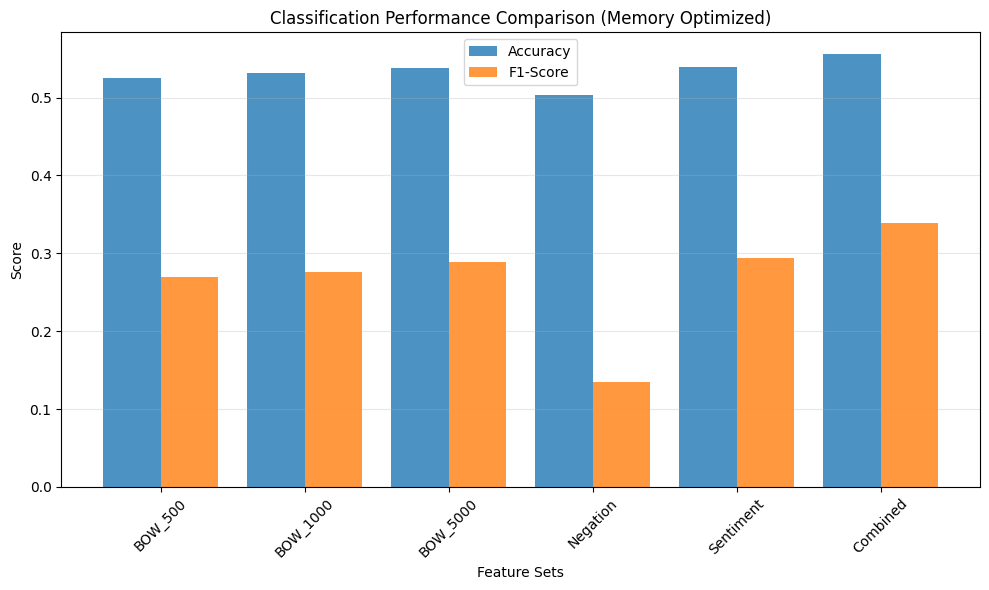

In [13]:


# Results summary
print(f"\n{'='*60}")
print("RESULTS SUMMARY")
print(f"{'='*60}")

for exp_name, scores in results.items():
    print(f"{exp_name:15} | Accuracy: {scores['accuracy']:.4f} | F1: {scores['f1']:.4f}")

# Simple visualization
experiment_names = list(results.keys())
accuracies = [results[exp]['accuracy'] for exp in experiment_names]
f1_scores = [results[exp]['f1'] for exp in experiment_names]

plt.figure(figsize=(10, 6))
x_pos = np.arange(len(experiment_names))

plt.bar(x_pos - 0.2, accuracies, 0.4, label='Accuracy', alpha=0.8)
plt.bar(x_pos + 0.2, f1_scores, 0.4, label='F1-Score', alpha=0.8)

plt.xlabel('Feature Sets')
plt.ylabel('Score')
plt.title('Classification Performance Comparison (Memory Optimized)')
plt.xticks(x_pos, experiment_names, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:


# Final analysis on a small test set
print(f"\n{'='*50}")
print("FINAL MODEL ANALYSIS")
print(f"{'='*50}")

# Use combined features for final analysis
sample_indices = random.sample(range(len(features_combined)), 2000)
X_sample = [features_combined[i] for i in sample_indices]
y_sample = [df['Sentiment'].iloc[i] for i in sample_indices]

# Convert to matrix
vec_final = DictVectorizer(sparse=True)
X_final = vec_final.fit_transform(X_sample)
y_final = np.array(y_sample)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=42)

# Train final model
final_model = LogisticRegression(max_iter=500, random_state=42, solver='liblinear')
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

print("Final Model Performance:")
print(classification_report(y_test, y_pred))

# Feature importance (top coefficients)
feature_names = vec_final.get_feature_names_out()
if hasattr(final_model, 'coef_'):
    # For binary classification, take absolute values
    if len(final_model.coef_) == 1:
        coeffs = np.abs(final_model.coef_[0])
    else:
        coeffs = np.abs(final_model.coef_).mean(axis=0)

    # Get top features
    top_indices = np.argsort(coeffs)[-15:]
    print(f"\nTop 15 Most Important Features:")
    for idx in reversed(top_indices):
        print(f"{feature_names[idx]}: {coeffs[idx]:.4f}")

print(f"\n{'='*50}")
print("MEMORY-EFFICIENT ANALYSIS COMPLETE!")
print(f"{'='*50}")
print("Key optimizations made:")
print("1. Reduced vocabulary size (500/1000 vs 1000/2000)")
print("2. Simplified feature functions")
print("3. Used sparse matrices")
print("4. Processed data in batches")
print("5. Used garbage collection")
print("6. Sampled large datasets")
print("7. Reduced cross-validation folds")


FINAL MODEL ANALYSIS
Final Model Performance:
              precision    recall  f1-score   support

           0       0.20      0.03      0.06        29
           1       0.36      0.15      0.21        99
           2       0.59      0.88      0.70       289
           3       0.46      0.37      0.41       138
           4       0.20      0.04      0.07        45

    accuracy                           0.54       600
   macro avg       0.36      0.30      0.29       600
weighted avg       0.47      0.54      0.48       600


Top 15 Most Important Features:
vader_compound_score: 1.3438
has_performance: 0.8688
has_flat: 0.7257
has_fantasy: 0.6769
has_first: 0.6768
has_bad: 0.6672
has_moments: 0.6614
has_like: 0.6570
vader_compound_neg: 0.6396
has_care: 0.6360
has_rather: 0.6351
has_screen: 0.6100
has_book: 0.6039
has_nice: 0.6026
has_better: 0.5928

MEMORY-EFFICIENT ANALYSIS COMPLETE!
Key optimizations made:
1. Reduced vocabulary size (500/1000 vs 1000/2000)
2. Simplified feature f

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction import DictVectorizer

# Recreate the feature matrix using combined features
print("Recreating feature matrix for evaluation...")
vec_eval = DictVectorizer(sparse=True)
X_features = vec_eval.fit_transform(features_combined)
y = df['Sentiment'].values  # Ensure y is a numpy array

# Evaluate on test set
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print evaluation
print("Accuracy:", model.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Recreating feature matrix for evaluation...
Accuracy: 0.549
              precision    recall  f1-score   support

           0       0.24      0.09      0.13        45
           1       0.40      0.20      0.27       180
           2       0.62      0.83      0.71       519
           3       0.39      0.34      0.36       202
           4       0.35      0.15      0.21        54

    accuracy                           0.55      1000
   macro avg       0.40      0.32      0.34      1000
weighted avg       0.50      0.55      0.51      1000

Confusion Matrix:
[[  4  15  18   6   2]
 [ 11  36 117  15   1]
 [  1  25 433  57   3]
 [  1  11 113  68   9]
 [  0   3  13  30   8]]


In [16]:
cv_results = cross_validate(model, X_features, y, cv=3, scoring=['accuracy', 'f1_macro'])
print("Cross-validated Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-validated F1 Score:", cv_results['test_f1_macro'].mean())


Cross-validated Accuracy: 0.5536017646410695
Cross-validated F1 Score: 0.34890831445983167
